## We scan the time delay stage to find the time_Zero 

This log is part of the data_analysis for 1st POLARIS XFEL beamtime at Desy, FLASH (Oct.2018)

(1) The optical laser will come in 10 Hz and xFEL comes in 10 Hz.

(2) we have two laser signals in HDF5 file, and in this script we will use the diode signal at the instrument side.

(3) !!!! we do a contineous slow delay scan !!!! and the delay scan rate is constant.

(4) Ni 3P peak will shift towrad higher kinetic energy position due to 2 electron excitation.

----------- 
 Created by  Hsin-Yi Wang (wang.hy@fysik.su.se), Date: 06-Oct-2018
 
- Note: This script shuld be operated under Python 3 environment 

### Import modules and useful function

In [16]:
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import h5py
import sys
from os import walk
import os.path
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.insert(0, '../src/')
import fit_data_tools
from fit_data_tools import *
import save_2_IGOR_file_05 as sif

### Import parameters 

In [17]:
files = [5] # file number, we store the data into Time_zero folder
thr_camera = 20
Int_time = float (1) # interval delay gap, unit = ps

### Start to do data analysis and polt out the filgure

['FLASH1_USER2_stream_2_run25147_file9_20181008T150745.1.h5'
 'FLASH1_USER2_stream_2_run25147_file19_20181008T153344.1.h5'
 'FLASH1_USER2_stream_2_run25147_file20_20181008T153620.1.h5'
 'FLASH1_USER2_stream_2_run25147_file14_20181008T152044.1.h5'
 'FLASH1_USER2_stream_2_run25147_file4_20181008T145447.1.h5'
 'FLASH1_USER2_stream_2_run25147_file2_20181008T144936.1.h5'
 'FLASH1_USER2_stream_2_run25147_file8_20181008T150509.1.h5'
 'FLASH1_USER2_stream_2_run25147_file18_20181008T153108.1.h5'
 'FLASH1_USER2_stream_2_run25147_file21_20181008T153856.1.h5'
 'FLASH1_USER2_stream_2_run25147_file12_20181008T151533.1.h5'
 'FLASH1_USER2_stream_2_run25147_file5_20181008T145723.1.h5'
 'FLASH1_USER2_stream_2_run25147_file15_20181008T152320.1.h5'
 'FLASH1_USER2_stream_2_run25147_file22_20181008T154132.1.h5'
 'FLASH1_USER2_stream_2_run25147_file17_20181008T152832.1.h5'
 'FLASH1_USER2_stream_2_run25147_file10_20181008T151021.1.h5'
 'FLASH1_USER2_stream_2_run25147_file13_20181008T151809.1.h5'
 'FLASH1_USER

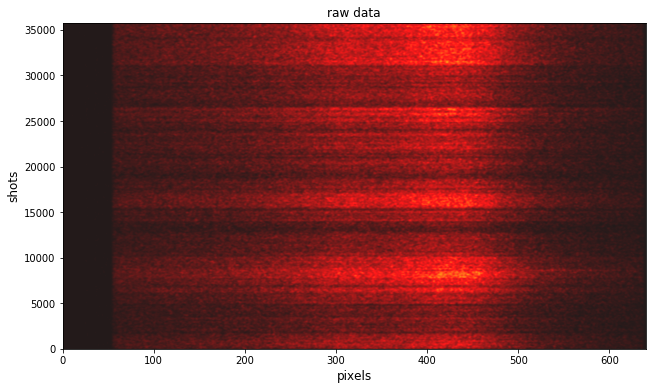

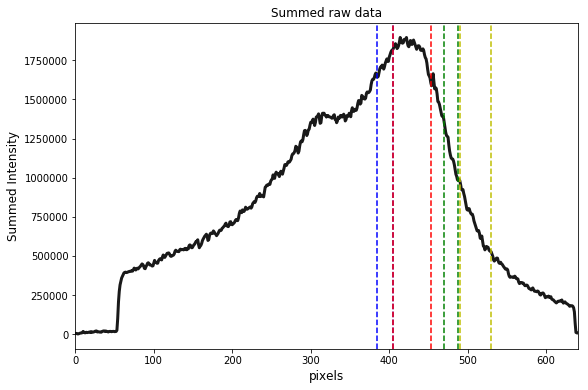

In [40]:
######################
# Load the data file #
######################
data_path = '../DATA/'+'Time_zero%03d/' %files[0]
if not os.path.exists(data_path) :
     raise NameError('Check data_path! It does not exist!')
data_names = discover_datas(data_path)
print (data_names)

#############################################
# Creating empty matirx for collecting data #
#############################################
Total_profile = []
Total_V = []
Total_delay = []
Binned_profile = []
Binned_delay = []

################
# Data process #
################
for i in range(len(data_names)):
    h5file = h5py.File(data_path+data_names[i], 'r')
    Image = h5file['/FL1/Experiment/Camera/PG/Basler FW 1/image/'].value
    Voltage_num = h5file['/FL1/Experiment/PG/SIS8300 100MHz ADC/CH6/TD/'].value
    #Delay_stage0 = h5file['/FL1/Experiment/Pump probe laser/laser delay'].value
    Delay_stage = h5file['/FL1/Experiment/Pump probe laser/delay line IK220.0/ENC'].value
    
    
    Image[Image<thr_camera] = 0
    for m in np.arange((Image.shape[0])):
        Ind_profile = np.sum(Image[m,:,:],axis = 1)
        Total_profile.append(Ind_profile)
    
    Ind_voltage_num = np.average(Voltage_num, axis = 1)
    Ind_voltage_num = Ind_voltage_num*650/(2**16)
    Total_V.extend(Ind_voltage_num)
            
    Total_delay.extend(Delay_stage[:,1])

    
Total_profile = np.array(Total_profile) 
Total_V = np.array(Total_V)
Total_V = np.nan_to_num(Total_V)
Total_delay = np.array(Total_delay)
Total_delay = np.nan_to_num(Total_delay)

Total_profile = Total_profile[np.all([Total_V>10, Total_delay!=0], axis = 0)]
Total_delay = Total_delay[np.all([Total_V>10, Total_delay!=0], axis = 0)]

Delay_start = float(Total_delay.min())
Delay_end = float(Total_delay.max())
Binned_delay.append(Delay_start)
print (Delay_start)
print(Delay_end)
############################################
# Plot out the 2D map data wothout binning #
############################################

plt.figure(figsize=[14,6])   
ax = plt.subplot(1,1,1)
plt.imshow(Total_profile,vmin=0,vmax=200, origin='lower', interpolation='bicubic',cmap='hot',alpha = 0.9)
plt.xlabel('pixels',size=12)
plt.ylabel('shots',size=12)
plt.title('raw data')
plt.xlim(0,640)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="4%", pad=0.1)
#plt.colorbar(cax=cax)
ax.set_aspect(aspect=0.01)
plt.show()

Spectrum = np.sum(Total_profile,axis = 0)
E_scale = np.arange(Spectrum.shape[0])
plt.figure(figsize=[9,6])
plt.plot(E_scale,Spectrum,ls = '-',linewidth ='3', c='black', alpha = 0.9)
plt.axvline(x=385,ls='--',c='b')
plt.axvline(x=405,ls='--',c='b')
plt.axvline(x=405,ls='--',c='r')
plt.axvline(x=453,ls='--',c='r')
plt.axvline(x=470,ls='--',c='g')
plt.axvline(x=488,ls='--',c='g')
plt.axvline(x=490,ls='--',c='y')
plt.axvline(x=530,ls='--',c='y')
plt.xlabel('pixels',size=12)
plt.ylabel('Summed Intensity',size=12)
plt.title('Summed raw data')
plt.xlim(0,640)
plt.show()

###########################################################
# Start to bin the data into desired delay time intervals #
###########################################################
Sum_0 = []
Sum_1 = []
Sum_2 = []
Sum_3 = []
d = 0
while (Delay_start + d*Int_time) < (Delay_end):
    mask = np.all([Total_delay >= (Delay_start + d*Int_time), Total_delay < (Delay_start + (d+1)*Int_time)], axis = 0)
    Int_Binned_profile = np.average(Total_profile[mask], axis = 0)
    Int_Binned_profile /= float(np.sum(Int_Binned_profile))
    Binned_profile.append(Int_Binned_profile)
    Binned_delay_mean = float(np.mean(Total_delay[mask]))
    Binned_delay.append(Binned_delay_mean)
    Sum_region_profile0 =float(np.sum (Int_Binned_profile[385:405]))
    Sum_region_profile1 =float(np.sum (Int_Binned_profile[405:453]))
    Sum_region_profile2 =float(np.sum (Int_Binned_profile[470:488]))
    Sum_region_profile3 =float(np.sum (Int_Binned_profile[490:530]))
    Sum_0.append(Sum_region_profile0)
    Sum_1.append(Sum_region_profile1)
    Sum_2.append(Sum_region_profile2)
    Sum_3.append(Sum_region_profile3)
    d = d + 1

Binned_profile = np.array(Binned_profile)
Binned_delay = np.array(Binned_delay)

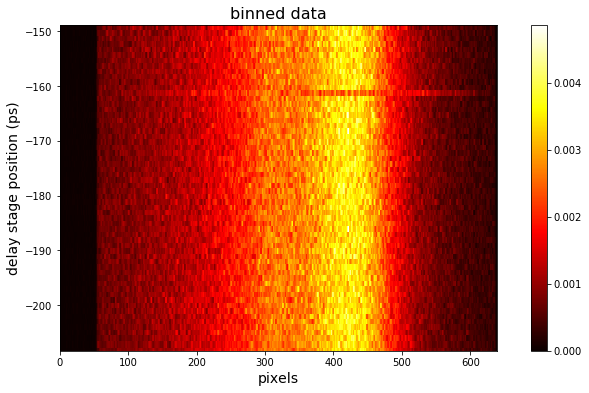

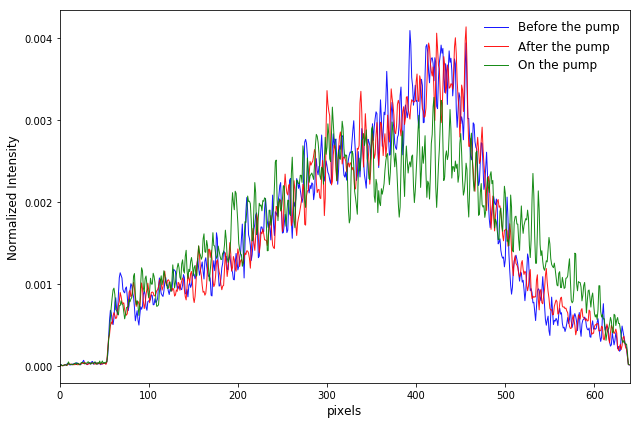

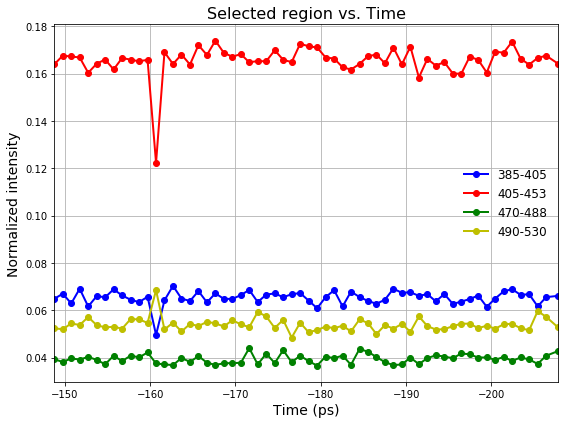

47
-160.690372166


In [41]:
##########################################
# Plot out the 2D map data after binning #
##########################################
a = np.arange(0,639.1,1)
b = Binned_delay
[x,y] = np.meshgrid(a,b)
z =Binned_profile
plt.figure(figsize=[12,6])   
ax = plt.subplot(1,1,1)
plt.pcolor(x,y,z, vmax = z.max(), cmap = 'hot')
plt.xlabel('pixels',size=14)
plt.ylabel('delay stage position (ps)',size=14)
plt.title('binned data', size = 16)
plt.colorbar()
ax.set_aspect(aspect=8)
plt.show()

Spectrum_1 = Binned_profile[44,:]
Spectrum_2 = Binned_profile[50,:]
Spectrum_3 = Binned_profile[47,:]
E_scale = np.arange(Spectrum_1.shape[0])
plt.figure(figsize=[9,6])
plt.plot(E_scale,Spectrum_1,ls = '-',linewidth ='1', c='b', alpha = 0.9, label = 'Before the pump')
plt.plot(E_scale,Spectrum_2,ls = '-',linewidth ='1', c='r', alpha = 0.9, label = 'After the pump')
plt.plot(E_scale,Spectrum_3,ls = '-',linewidth ='1', c='g', alpha = 0.9, label = 'On the pump')
plt.xlabel('pixels',size=12)
plt.ylabel('Normalized Intensity',size=12)
plt.xlim(0,640)
plt.legend(frameon=False,loc='best', prop={'size': 12})
plt.tight_layout()
plt.show()

Time = Binned_delay[1:]
plt.figure(figsize=[8,6])
plt.plot(Time,Sum_0,'o-',linewidth ='2', c='b', label = '385-405')
plt.plot(Time,Sum_1,'o-',linewidth ='2', c='red', label = '405-453')
plt.plot(Time,Sum_2,'o-',linewidth ='2', c='g', label = '470-488')
plt.plot(Time,Sum_3,'o-',linewidth ='2', c='y', label = '490-530')
plt.xlim(Time.max(), Time.min())
plt.xlabel('Time (ps)',size=14)
plt.ylabel('Normalized intensity',size=14)
plt.title('Selected region vs. Time', size = 16)
plt.grid(True)
plt.legend(frameon=False,loc='best', prop={'size': 12})
plt.tight_layout()
plt.show()

Min = int(np.argmin(Sum_1))
print(Min)
print(Time[Min])

In [26]:
x = -30+60*(160.6934-148.75711)/(208.33029-148.75711)
print(x)

-17.97819085702661
